<a href="https://colab.research.google.com/github/shameemudheenedt/LAS--DCS/blob/master/MM_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [2]:
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:14:41tcmalloc: large alloc 1147494400 bytes == 0x3a458000 @  0x7f27d6312615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:19tcmalloc: large alloc 1434370048 bytes == 0x7eaae000 @  0x7f27d6312615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [4]:
# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     |████████████████████████████████| 46.3 MB 8.1 MB/s 
     |████████████████████████████████| 190 kB 5.0 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 24959, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 24959 (delta 9), reused 24 (delta 2), pack-reused 24916
Receiving objects: 100% (24959/24959), 37.78 MiB | 33.87 MiB/s, done.
Resolving deltas: 100% (17476/17476), done.
/content/mmdetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet


In [6]:
from mmcv import collect_env
collect_env()

{'CUDA available': True,
 'CUDA_HOME': '/usr/local/cuda',
 'GCC': 'x86_64-linux-gnu-gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'GPU 0': 'Tesla T4',
 'MMCV': '1.5.3',
 'MMCV CUDA Compiler': '11.1',
 'MMCV Compiler': 'GCC 7.3',
 'NVCC': 'Cuda compilation tools, release 11.1, V11.1.105',
 'OpenCV': '4.1.2',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=comp

In [7]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.25.0
11.1
GCC 7.3


In [8]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth

--2022-06-19 11:54:11--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291982 (160M) [application/octet-stream]
Saving to: ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’

checkpoints/faster_ 100%[===================>] 159.54M  8.88MB/s    in 18s     

2022-06-19 11:54:30 (8.79 MB/s) - ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’ saved [167291982/167291982]



In [10]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [14]:
# Use the detector to do inference
img = '/content/mumbai.jpg'
result = inference_detector(model, img)

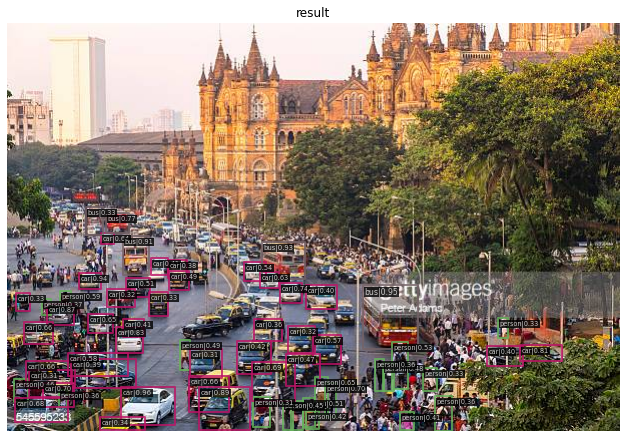

In [15]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)